In [24]:
def gen_dataset(target_dir, music_dir="../Data/music/music_only/", voice_dir="../Data/voice/", voice_amp_ratio=0.5, train_test_split : float=False, random_state : int=None) : 
    """Generate datasets with given `directories` : `music_dir`, `voice_dir`

    Given voice data will be randomly selected to merge with music.

    ### Args : 

    [`train_test_split`]
        - Merged dataset will be stored at `target_dir`. 
        - If `train_test_split` were given, the datasets will be splited in two directories - `[train_data]`, `[test_data]`
        - If `train_test_split` were not given, every dataset will be stored to `[train_data]` directory.

    [`voice_amp_ratio`]
        - The ratio to synchronize voice amplitude with music.
        - Specific ratio will be calculated by Mean Absolute value of given data.

    [`random_state`]
        - The RandomState to shuffle voice dataset.
        - Use np.random.RandomState

    Raises : 
        AssertionError: if same file exists in `target_dir`, raise AssertionError
    ---
    ### code example
    ```python
        target_dir = "./test_dir"
        music_dir = "../Data/music/music_only/"
        voice_dir = "../Data/voice/"

        gen_dataset(
            target_dir=target_dir, music_dir=music_dir, voice_dir=voice_dir, 
            voice_amp_ratio=0.5, train_test_split=0.5, random_state=198234
        )
    ```
    ---
    ### shell output
    ```shell
        ./test_dir
        ├── test_data
        │   ├── merge_002.wav
        │   ├── music_002.wav
        │   └── voice_002.wav
        └── train_data
            ├── merge_001.wav
            ├── music_001.wav
            └── voice_001.wav

        3 directories, 6 files
    ```
    ---
    """
    import librosa, os, time, sys, warnings
    import numpy as np

    from threading import Thread
    from numpy.random import RandomState
    from IPython.display import Audio

    warnings.filterwarnings(action="ignore")
    shuffle_list = lambda List, Random_state : Random_state.shuffle(List)
    mean_amp = lambda Array : np.abs(Array).mean()

    def gen_data() : 
        nonlocal music_path
        nonlocal voice_path_list, Rand_state, voice_amp_ratio
        nonlocal target_dir, count
        
        sample_rate = librosa.get_samplerate(path=music_path)
        music_source = librosa.load(path=music_path, sr=sample_rate)[0]

        merge_array = np.zeros_like(music_source, dtype=music_source.dtype)
        voice_array = np.zeros_like(music_source, dtype=music_source.dtype)

        pivot = 0
        total_length = len(music_source)
        while True : 
            voice_path = voice_path_list[0]
            voice_source = librosa.load(path=voice_path, sr=sample_rate)[0]
            shuffle_list(voice_path_list, Rand_state)

            if len(voice_source) >= total_length : 
                del voice_source
                continue
            
            alter_pivot = len(voice_source)
            
            flag = False
            if pivot + alter_pivot > total_length : 
                music_mean_amp = mean_amp(music_source[pivot:])
                voice_mean_amp = mean_amp(voice_source[:int(len(merge_array) - pivot)])
                alpha = music_mean_amp * voice_amp_ratio / voice_mean_amp
                # music * ratio = voice * alpha
                if alpha == 0 : 
                    alpha = 1
                
                if voice_mean_amp : 
                    merge_array[pivot:] = music_source[pivot:] + voice_source[:int(len(merge_array) - pivot)] * alpha
                    voice_array[pivot:] = voice_source[:int(len(merge_array) - pivot)] * alpha
                    flag = True
            
            else : 
                music_mean_amp = mean_amp(music_source[pivot:pivot + alter_pivot])
                voice_mean_amp = mean_amp(voice_source)
                alpha = music_mean_amp * voice_amp_ratio / voice_mean_amp
                # music * ratio = voice * alpha
                if alpha == 0 : 
                    alpha = 1
                
                if voice_mean_amp : 
                    merge_array[pivot:pivot + alter_pivot] = music_source[pivot:pivot + alter_pivot] + voice_source * alpha
                    voice_array[pivot:pivot + alter_pivot] = voice_source * alpha
                    pivot += alter_pivot
            
            del voice_source
            if flag : break

        merge_audio = Audio(data=merge_array, rate=sample_rate)
        voice_audio = Audio(data=voice_array, rate=sample_rate)
        music_audio = Audio(data=music_source, rate=sample_rate)

        for source_type, audio in zip(["merge", "voice", "music"], [merge_audio, voice_audio, music_audio]) : 
            data_dir = target_dir + source_type + "_{}.wav".format(str(count).zfill(3))
            if os.path.exists(data_dir) : 
                raise AssertionError("File [{}.wav] already exists in [{}] directory".format(count, target_dir))
            with open(file=data_dir, mode="wb") as f : 
                f.write(audio.data)
        
        del music_source, merge_array, merge_audio, voice_audio, music_audio

    def check_status(current, total) : 
        nonlocal stdout_list
        string = "\rProcessing... [{}] : ".format(stdout_list[0]).ljust(15)
        string += "[{}/{}]".format(str(current).zfill(3), str(total).zfill(3))
        sys.stdout.write(string)
        sys.stdout.flush()
        stdout_list.append(stdout_list.pop(0))

    musics = os.listdir(music_dir)
    voices = os.listdir(voice_dir)

    assert len(musics), AssertionError("Music directory is empty.")
    assert len(voices), AssertionError("Voice directory is empty.")

    music_path_list = [music_dir + string for string in musics]
    voice_path_list = [voice_dir + string for string in voices]

    target_dir = target_dir + "/" if target_dir[-1] != "/" else target_dir
    if not os.path.isdir(target_dir) : 
        os.makedirs(target_dir)
        os.makedirs(target_dir + "train_data/")
        os.makedirs(target_dir + "test_data/")
        count = 1
    else : 
        count = len(os.listdir(target_dir)) + 1

    Rand_state = RandomState(random_state)
    shuffle_list(voice_path_list, Rand_state)

    current = 1
    total = len(music_path_list)

    if train_test_split : 
        split_index = int(total * train_test_split)
        train_music_path_list = music_path_list[split_index:]
        test_music_path_list = music_path_list[:split_index]
    else : 
        train_music_path_list = music_path_list
        test_music_path_list = []
    
    stdout_list = "/-\|"
    stdout_list = list(stdout_list)
    
    prev_target_dir = target_dir
    target_dir = prev_target_dir + "train_data/"
    for music_path in train_music_path_list : 
        t1 = Thread(target=gen_data)
        
        t1.start()
        while t1.is_alive() : check_status(current, total), time.sleep(0.15)
        t1.join()

        count += 1
        current += 1
        del t1
    
    target_dir = prev_target_dir + "test_data/"
    for music_path in test_music_path_list : 
        t1 = Thread(target=gen_data)
        
        t1.start()
        while t1.is_alive() : check_status(current, total), time.sleep(0.15)
        t1.join()

        count += 1
        current += 1
        del t1
    
    print("\t  Done")


In [25]:
target_dir = "./test_dir"
music_dir = "../Data/music/music_only/"
voice_dir = "../Data/voice/"

gen_dataset(
    target_dir=target_dir, music_dir=music_dir, voice_dir=voice_dir, 
    voice_amp_ratio=0.5, train_test_split=0.5, random_state=198234
)

Processing... [-] : [002/002]	  Done


In [26]:
!tree "./test_dir"

./test_dir
├── test_data
│   ├── merge_002.wav
│   ├── music_002.wav
│   └── voice_002.wav
└── train_data
    ├── merge_001.wav
    ├── music_001.wav
    └── voice_001.wav

3 directories, 6 files


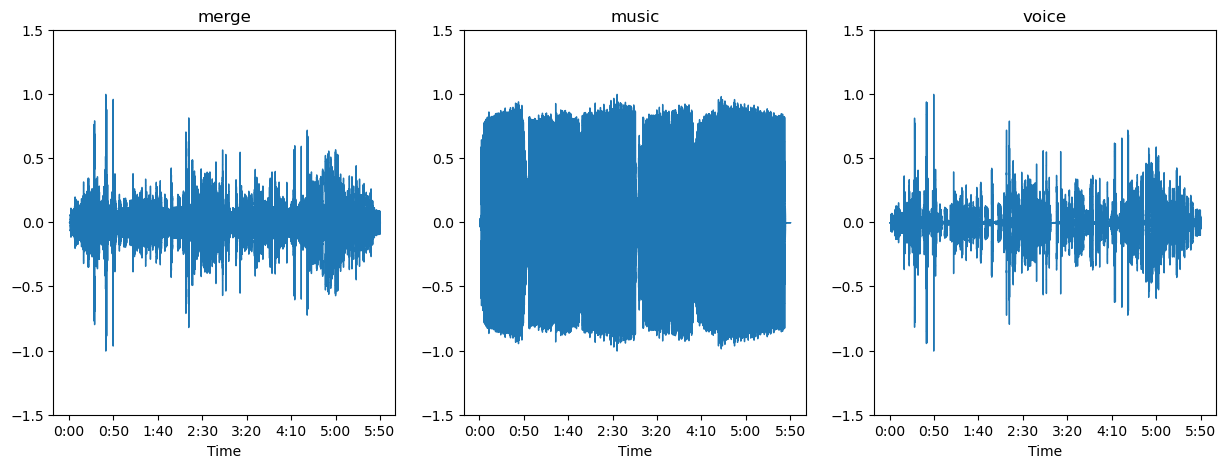

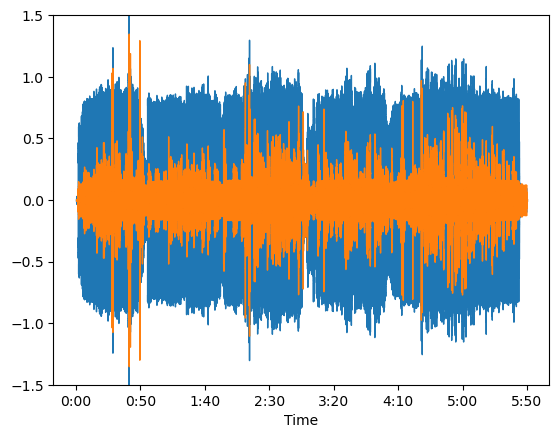

In [27]:
import librosa, shutil
import numpy as np
import matplotlib.pyplot as plt

path_merge = "./test_dir/test_data/merge_002.wav"
path_music = "./test_dir/test_data/music_002.wav"
path_voice = "./test_dir/test_data/voice_002.wav"
sample_rate = librosa.get_samplerate(path_merge)

source_merge = librosa.load(path_merge, sr=sample_rate)[0]
source_music = librosa.load(path_music, sr=sample_rate)[0]
source_voice = librosa.load(path_voice, sr=sample_rate)[0]

fig ,axes = plt.subplots(ncols=3, figsize=(15, 5))

title_list = ["merge", "music", "voice"]
for ax, source, title in zip(axes, [source_merge, source_music, source_voice], title_list) : 
    librosa.display.waveshow(source, sr=sample_rate, ax=ax)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(title)
plt.show()


librosa.display.waveshow(source_music + source_voice, sr=sample_rate)
librosa.display.waveshow(source_merge * 1.35, sr=sample_rate)
plt.ylim(-1.5, 1.5)
plt.show()

shutil.rmtree(target_dir + "/")